In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sqlite3
import numpy as np
import pandas as pd
import eofs.standard as eofs
import pylab as plt
import scipy.stats as stats
import scipy.signal as signal
from mpl_toolkits.basemap import Basemap
import tools

In [3]:
plt.style.use("coolbeans")

In [4]:
DB_PATH = "./data/stationdb.sqlite"
ERAI_PATH = "./data/erai.npz"
OISST_PATH = "./data/oisst.npz"
SHORTCALYEAR_LOW = 1982
SHORTCALYEAR_HIGH = 2012
LONGCALYEAR_LOW = 1949
LONGCALYEAR_HIGH = 2011
WESTOFLON = -104
EASTOFLON = -125

This is the important part. We're pulling `target_stations` as we would in the EOF analysis of older USGS river gages but we run it using the code for the younger-station EOF analysis.

In [5]:
# Grab data from SQLITE3 DB.
target_stations = [i for i in tools.check_monthly(DB_PATH, LONGCALYEAR_LOW, LONGCALYEAR_HIGH, WESTOFLON, EASTOFLON)]
conn = sqlite3.connect(DB_PATH)
sql_query = "SELECT stationid, wy, avg(mean) FROM StationMonthly WHERE wy <= 2012 AND wy >= 1983 AND stationid IN ({seq}) GROUP BY stationid, wy ORDER BY stationid, wy ASC".format(seq = ",".join(["?"] * len(target_stations)))
raw = pd.read_sql(sql_query, conn, params = target_stations, index_col = ["wy", "stationid"])
conn.close()

In [6]:
# Get corresponding latitude and longitude.
conn = sqlite3.connect(DB_PATH)
sql_query = "SELECT stationid, latgage, longage FROM StationInfo WHERE stationid IN ({seq}) ORDER BY stationid ASC".format(seq = ",".join(["?"] * len(target_stations)))
latlon = pd.read_sql(sql_query, conn, params = target_stations)
conn.close()

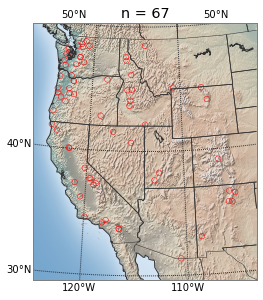

In [7]:
# Plot simple sample map.
lon, lat = latlon["longage"].as_matrix(), latlon["latgage"].as_matrix()
plt.figure(figsize = (4, 6))
m = Basemap(width = 2000000, height = 2300000, 
            resolution = 'l', projection = 'stere', 
            lat_ts = 40.0, 
            lat_0 = 40.0, lon_0 = -114.0)
# m.drawmapboundary()
m.drawcoastlines(color = "#333333")
m.drawstates(linewidth = 0.7, color = "#333333")
m.drawcountries(color = "#333333")
m.shadedrelief()
parallels = np.arange(0., 81, 10)
m.drawparallels(parallels, labels = [True, False, True, False], color = "#333333")
meridians = np.arange(10., 351., 10)
m.drawmeridians(meridians, labels = [False, True, False, True], color = "#333333")
m.scatter(lon, lat, s = 30, marker = 'o', latlon = True, facecolors = "none", edgecolors='r')
plt.title("n = " + str(len(target_stations)))
plt.show()

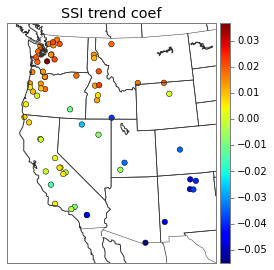

In [8]:
# Parse and shape the data we grabbed. Standardize it. Grad trend coefficients.
parsed = raw.groupby(level = "stationid")["avg(mean)"].transform(tools.spigamma)

def trender(y):
    A = np.vstack([np.arange(len(y)), np.ones(len(y))]).T
    m, c = np.linalg.lstsq(A, y)[0]
    return m
trend_coefs = parsed.groupby(level = "stationid").apply(trender)

parsed = parsed.unstack()

# Map trend coefs.
lon, lat = latlon["longage"].as_matrix(), latlon["latgage"].as_matrix()
plt.figure(figsize = (4, 6))
m = Basemap(width = 2000000, height = 2300000, 
            resolution = 'l', projection = 'stere', 
            lat_ts = 40.0, 
            lat_0 = 40.0, lon_0 = -114.0)
m.drawcoastlines(color = "#333333")
m.drawstates(linewidth = 0.7, color = "#333333")
m.drawcountries(color = "#333333")
m.scatter(lon, lat, c = trend_coefs.tolist(), s = 30, latlon = True, edgecolors='k')
m.colorbar()
plt.title("SSI trend coef")
plt.show()

In [9]:
# Interesting iterations are:
# 1) standardized, correlation or covariance (`center = True` in this case).
# 2) Non-standardized correlation.

solver = eofs.Eof(parsed.as_matrix(), center = False)
eof = solver.eofsAsCovariance(neofs = 6)
pc = solver.pcs(npcs = 6, pcscaling = 1)
frac_var = solver.varianceFraction(6)

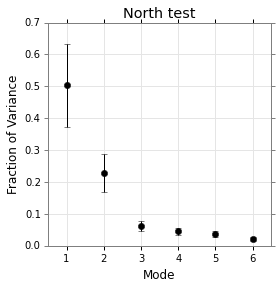

In [10]:
# Basic North Test plot
plt.figure(figsize = (4, 4))
plt.errorbar(np.arange(len(frac_var))+1, frac_var, yerr = solver.northTest(len(frac_var), vfscaled = True), fmt = "o")
plt.xlim(0.5, len(frac_var) + 0.5)
plt.title("North test")
plt.xlabel("Mode")
plt.ylabel("Fraction of Variance")
plt.show()

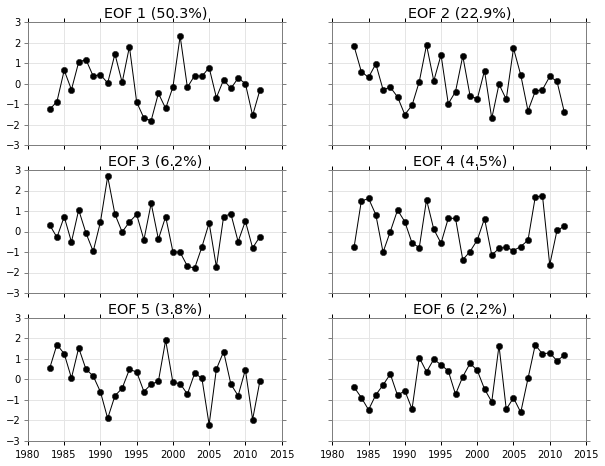

In [11]:
# Plot 6 leading PCs.
yr = np.arange(SHORTCALYEAR_LOW + 1, SHORTCALYEAR_HIGH + 1)
fig, axes = plt.subplots(figsize = (10, 7.5), nrows = 3, ncols = 2, sharex = True, sharey = True)
# fig.add_axes([0.1, 0.1, 0.8, 0.8])
for i in range(6):
    axes.flat[i].plot(yr, pc[:, i], "-o")
#     axes.flat[i].plot(yr, pc[:, i], ".")
    axes.flat[i].set_title("EOF " + str(i + 1) + " (" + str(np.round(frac_var[i] * 100, 1)) + "%)")
plt.show()

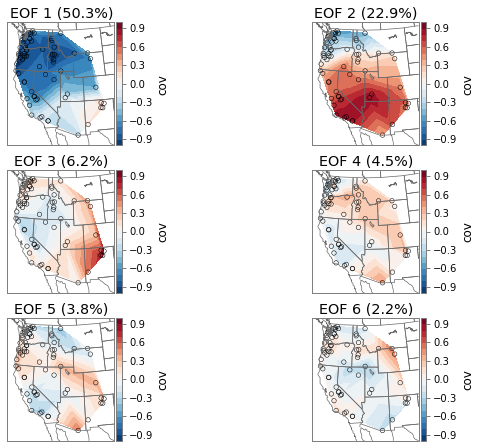

In [12]:
# Plot 6 leading EOFs.
fig, axes = plt.subplots(figsize = (10, 7.5), nrows = 3, ncols = 2)
for i in range(6):
    m = Basemap(ax = axes.flat[i], width = 2000000, height = 2300000, 
                resolution = 'l', projection = 'stere', 
                lat_ts = 40.0, 
                lat_0 = 40.0, lon_0 = -114.0)
    x, y = m(latlon["longage"].as_matrix(), latlon["latgage"].as_matrix())
    m.drawcoastlines(linewidth = 0.7, color = "#696969")
    m.drawstates(linewidth = 0.7, color = "#696969")
    m.drawcountries(linewidth = 0.7, color = "#696969")
    divs = np.linspace(-1, 1, 21)
#     ctf1 = m.contourf(x, y, eof[i].squeeze(), tri = True)
    ctf1 = m.contourf(x, y, eof[i].squeeze(), divs, cmap = plt.cm.RdBu_r, tri = True)
    cb = m.colorbar(ctf1)
    cb.set_label("cov")
    m.scatter(x, y, facecolors = "none", edgecolor = "k")
    axes.flat[i].set_title("EOF " + str(i + 1) + " (" + str(np.round(frac_var[i] * 100, 1)) + "%)")
plt.show()

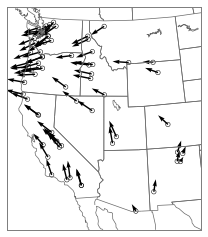

In [13]:
rcoef1 = parsed.stack().groupby(level = "stationid").aggregate(lambda x: stats.linregress(pc[:, 0], x)[0])
rcoef2 = parsed.stack().groupby(level = "stationid").aggregate(lambda x: stats.linregress(pc[:, 1], x)[0])
# print(rcoef1)
# print(rcoef2)
plt.figure(figsize = (5, 4))
m = Basemap(width = 2000000, height = 2300000, 
            resolution = 'l', projection = 'stere', 
            lat_ts = 40.0, 
            lat_0 = 40.0, lon_0 = -114.0)
x, y = m(latlon["longage"].as_matrix(), latlon["latgage"].as_matrix())
m.drawcoastlines(linewidth = 0.7, color = "#696969")
m.drawstates(linewidth = 0.7, color = "#696969")
m.drawcountries(linewidth = 0.7, color = "#696969")
m.quiver(x, y, rcoef1, rcoef2, scale = 10)
m.scatter(x, y, facecolors = "none", edgecolor = "k")
plt.show()

In [14]:
# Correlate PCs with reanalysis data at NDJ mean 500 mb height anomalies.
erai = np.load(ERAI_PATH)
msk_time = (erai["time"] >= SHORTCALYEAR_LOW + 1) & (erai["time"] <= SHORTCALYEAR_HIGH)
hgts = erai["data"][0, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
hgts_oldshape = hgts.shape
hgts.shape = (hgts_oldshape[0], hgts_oldshape[1] * hgts_oldshape[2])
r = np.empty((pc.shape[1], hgts_oldshape[1] * hgts_oldshape[2]))
p = np.empty(r.shape)
for i in range(pc.shape[1]):
    pc_target = pc[:, i]
    for j in range(hgts.shape[1]):
            r[i, j], p[i, j] = stats.pearsonr(pc_target, hgts[:, j])
r.shape = (pc.shape[1], hgts_oldshape[1], hgts_oldshape[2])
p.shape = r.shape

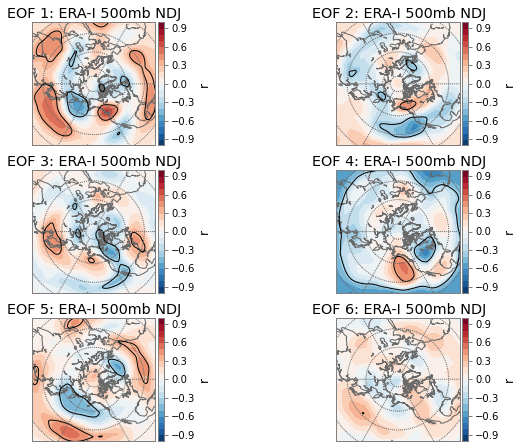

In [15]:
# Plot NDJ 500 mb point correlations.
fig, axes = plt.subplots(figsize = (10, 7.5), nrows = 3, ncols = 2)
divs = np.linspace(-1, 1, 21)
for i in range(pc.shape[1]):
    m = Basemap(ax = axes.flat[i], projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
    x, y = m(erai["lon"], erai["lat"])
    m.drawcoastlines(color = "#696969")
    m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
    m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
    ctf1 = m.contourf(x, y, r[i], divs, cmap = plt.cm.RdBu_r)
    ctf2 = m.contour(x, y, p[i], [0.05], colors = "k")
    cb = m.colorbar(ctf1)
    cb.set_label("r")
    axes.flat[i].set_title("EOF " + str(i + 1) + ": ERA-I 500mb NDJ")
plt.show()

In [16]:
# Correlate PCs with OI SST data (NDJ mean) detrended anomalies.
oisst = np.load(OISST_PATH)
msk_time = (oisst["time"] >= SHORTCALYEAR_LOW + 1) & (oisst["time"] <= SHORTCALYEAR_HIGH)
sst = oisst["data"][0, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
sst_oldshape = sst.shape
sst.shape = (sst_oldshape[0], sst_oldshape[1] * sst_oldshape[2])
r = np.empty((pc.shape[1], sst.shape[1]))
p = np.empty(r.shape)
for i in range(pc.shape[1]):
    pc_target = pc[:, i]
    for j in range(sst.shape[1]):
            if ~(oisst["landmask"].flat[j] == True):
                r[i, j], p[i, j] = stats.pearsonr(pc_target, sst[:, j])
r.shape = (pc.shape[1], sst_oldshape[1], sst_oldshape[2])
p.shape = r.shape

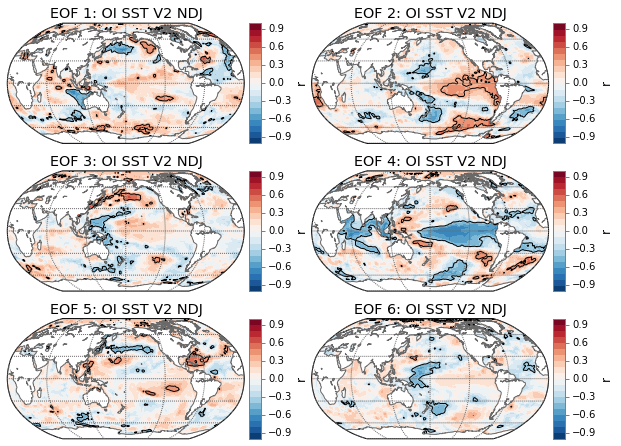

In [17]:
# Plot NDJ sst point correlations.
fig, axes = plt.subplots(figsize = (10, 7.5), nrows = 3, ncols = 2)
divs = np.linspace(-1, 1, 21)
for i in range(6):
    r_msked = np.ma.masked_array(r[i], oisst["landmask"])
    p_msked = np.ma.masked_array(p[i], oisst["landmask"])
    m = Basemap(ax = axes.flat[i], projection = "robin", lon_0 = 180, resolution = "c")
    x, y = m(oisst["lon"], oisst["lat"])
    m.drawcoastlines(color = "#696969")
    m.drawparallels(np.arange(-90.,120.,30.), color = "#696969")
    m.drawmeridians(np.arange(0.,360.,60.), color = "#696969")
    ctf1 = m.contourf(x, y, r_msked, divs, cmap = plt.cm.RdBu_r)
    ctf2 = m.contour(x, y, p_msked, [0.05], colors = "k")
    cb = m.colorbar(ctf1)
    cb.set_label("r")
    axes.flat[i].set_title("EOF " + str(i + 1) + ": OI SST V2 NDJ")
plt.show()

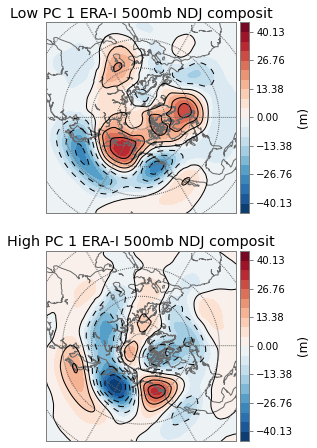

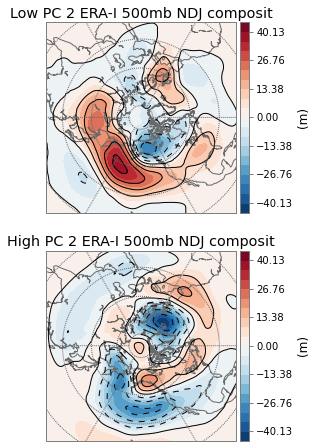

PC1 low+high:
[1983 1984 1995 1996 1997 1999 2006 2011]
[1985 1987 1988 1990 1992 1994 2001 2005]
PC2 low+high:
[1990 1991 1996 2000 2002 2004 2007 2012]
[1983 1984 1986 1993 1995 1998 2001 2005]


In [18]:
# Composite map of NDJ mean 500 mb height anomalies.
erai = np.load(ERAI_PATH)
msk_time = (erai["time"] >= SHORTCALYEAR_LOW + 1) & (erai["time"] <= SHORTCALYEAR_HIGH)
hgts = erai["data"][0, 1, msk_time]

# First dim is PC, second is 0 -> low, 1 -> high:
composit_anoms = np.zeros((2, 2, hgts.shape[1], hgts.shape[2]))
for i in range(2):
    quarts = pd.qcut(pc[:, i], [0, 0.25, 0.75, 1], labels = ["low", "mid", "high"])
    composit_anoms[i, 0] = np.mean(hgts[(quarts == "low")], 0) - np.mean(hgts, 0)
    composit_anoms[i, 1] = np.mean(hgts[(quarts == "high")], 0) - np.mean(hgts, 0)

wings = np.max([np.absolute(composit_anoms.min()), np.absolute(composit_anoms.max())])
divs = np.linspace(-wings, wings, 21)
divs2 = np.linspace(-wings, wings, 11)
fig, axes = plt.subplots(figsize = (8, 7.5), nrows = 2, ncols = 1)
for i in range(2):
    m = Basemap(ax = axes.flat[i], projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
    x, y = m(erai["lon"], erai["lat"])
    m.drawcoastlines(color = "#696969")
    m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
    m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
    m.contour(x, y, composit_anoms[0, i], divs2, colors = "k")
    pcol = m.contourf(x, y, composit_anoms[0, i], divs, cmap = plt.cm.RdBu_r)
    cb = m.colorbar(pcol)
    cb.set_label("(m)")
    axes.flat[i].set_title(("Low", "High")[i]+" PC 1" + " ERA-I 500mb NDJ composit")
plt.show()
    
fig, axes = plt.subplots(figsize = (8, 7.5), nrows = 2, ncols = 1)
for i in range(2):
    m = Basemap(ax = axes.flat[i], projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
    x, y = m(erai["lon"], erai["lat"])
    m.drawcoastlines(color = "#696969")
    m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
    m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
    m.contour(x, y, composit_anoms[1, i], divs2, colors = "k")
    pcol = m.contourf(x, y, composit_anoms[1, i], divs, cmap = plt.cm.RdBu_r)
    cb = m.colorbar(pcol)
    cb.set_label("(m)")    
    axes.flat[i].set_title(("Low", "High")[i]+" PC 2" + " ERA-I 500mb NDJ composit")
plt.show()

quarts = pd.qcut(pc[:, 0], [0, 0.25, 0.75, 1], labels = ["low", "mid", "high"])
print("PC1 low+high:")
print(yr[quarts == "low"])
print(yr[quarts == "high"])
quarts = pd.qcut(pc[:, 1], [0, 0.25, 0.75, 1], labels = ["low", "mid", "high"])
print("PC2 low+high:")
print(yr[quarts == "low"])
print(yr[quarts == "high"])

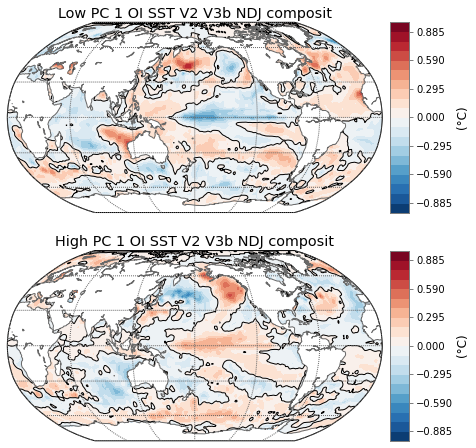

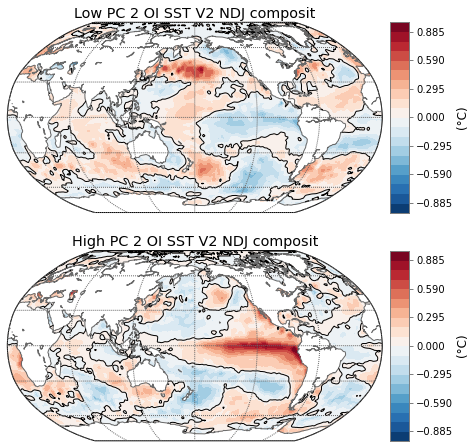

PC1 low+high:
[1983 1984 1995 1996 1997 1999 2006 2011]
[1985 1987 1988 1990 1992 1994 2001 2005]
PC2 low+high:
[1990 1991 1996 2000 2002 2004 2007 2012]
[1983 1984 1986 1993 1995 1998 2001 2005]


In [19]:
# Composite map of NDJ detrended sea surface temperature anomalies.
oisst = np.load(OISST_PATH)
msk_time = (oisst["time"] >= SHORTCALYEAR_LOW + 1) & (oisst["time"] <= SHORTCALYEAR_HIGH)
sst = oisst["data"][0, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")

# First dim is PC, second is 0 -> low, 1 -> high:
composit_anoms = np.zeros((2, 2, sst.shape[1], sst.shape[2]))
for i in range(2):
    quarts = pd.qcut(pc[:, i], [0, 0.25, 0.75, 1], labels = ["low", "mid", "high"])
    composit_anoms[i, 0] = np.mean(sst[(quarts == "low")], 0) - np.mean(sst, 0)
    composit_anoms[i, 1] = np.mean(sst[(quarts == "high")], 0) - np.mean(sst, 0)

wings = np.max([np.absolute(composit_anoms.min()), np.absolute(composit_anoms.max())])
divs = np.linspace(-wings, wings, 21)
fig, axes = plt.subplots(figsize = (8, 7.5), nrows = 2, ncols = 1)
for i in range(2):
    c = np.ma.masked_array(composit_anoms[0, i], oisst["landmask"])
    m = Basemap(ax = axes.flat[i], projection = "robin", lon_0 = 180, resolution = "c")
    x, y = m(oisst["lon"], oisst["lat"])
    m.drawcoastlines(color = "#696969")
    m.drawparallels(np.arange(-90.,120.,30.), color = "#696969")
    m.drawmeridians(np.arange(0.,360.,60.), color = "#696969")
    m.contour(x, y, c, divs2, colors = "k")
    pcol = m.contourf(x, y, c, divs, cmap = plt.cm.RdBu_r)
    cb = m.colorbar(pcol)
    cb.set_label("(°C)")
    axes.flat[i].set_title(("Low", "High")[i]+" PC 1" + " OI SST V2 V3b NDJ composit")
plt.show()

fig, axes = plt.subplots(figsize = (8, 7.5), nrows = 2, ncols = 1)
for i in range(2):
    c = np.ma.masked_array(composit_anoms[1, i], oisst["landmask"])
    m = Basemap(ax = axes.flat[i], projection = "robin", lon_0 = 180, resolution = "c")
    x, y = m(oisst["lon"], oisst["lat"])
    m.drawcoastlines(color = "#696969")
    m.drawparallels(np.arange(-90.,120.,30.), color = "#696969")
    m.drawmeridians(np.arange(0.,360.,60.), color = "#696969")
    m.contour(x, y, c, divs2, colors = "k")
    pcol = m.contourf(x, y, c, divs, cmap = plt.cm.RdBu_r)
    cb = m.colorbar(pcol)
    cb.set_label("(°C)")
    axes.flat[i].set_title(("Low", "High")[i]+" PC 2" + " OI SST V2 NDJ composit")
plt.show()

quarts = pd.qcut(pc[:, 0], [0, 0.25, 0.75, 1], labels = ["low", "mid", "high"])
print("PC1 low+high:")
print(yr[quarts == "low"])
print(yr[quarts == "high"])
quarts = pd.qcut(pc[:, 1], [0, 0.25, 0.75, 1], labels = ["low", "mid", "high"])
print("PC2 low+high:")
print(yr[quarts == "low"])
print(yr[quarts == "high"])